<a href="https://colab.research.google.com/github/tnwls6865/CAU_mAI/blob/main/Week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Visualize Filters

In [2]:
import numpy as np 

class TwoLayerNet(object):
  """
  
  input - fully connected layer - ReLU - fully connected layer - softmax

  """

  def __init__(self, input_size, hidden_size, output_size, std=1e-4):
    """

    W1: First layer weights; has shape (D, H)
    b1: First layer biases; has shape (H,)
    W2: Second layer weights; has shape (H, C)
    b2: Second layer biases; has shape (C,)

    Inputs:
    - input_size: The dimension D of the input data.
    - hidden_size: The number of neurons H in the hidden layer.
    - output_size: The number of classes C.
    """
    self.params = {}
    self.params['W1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = std * np.random.randn(hidden_size)  + 0.5  # np.zeros(hidden_size) 
    self.params['W2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def loss(self, X, y=None, reg=0.0):
    
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    N, D = X.shape

    # Compute the forward pass
    scores = None
    #############################################################################
    # TODO: Perform the forward pass, computing the class scores for the input. #
    # Store the result in the scores variable, which should be an array of      #
    # shape (N, C).                                                             #
    #############################################################################
    
    z = np.dot(X, W1) + b1  # (N, num_hidden)
    h = np.maximum(z, 0)    # ReLU
    scores = np.dot(h , W2) + b2 

    if y is None:
      return scores

    # Compute the loss
    loss = 0.0
  
    # compute softmax probabilities
    out = np.exp(scores)      # (N, C)
    out /= np.sum(out, axis=1).reshape(N, 1)
    
    # compute softmax loss
    loss -= np.sum(np.log(out[np.arange(N), y]))
    loss /= N
    loss += 0.5 * reg * (np.sum(W1**2) + np.sum(W2**2))
    
    # Backward pass : gradient계산
    grads = {}

    # back propagation
    dout = np.copy(out)  # (N, C)
    dout[np.arange(N), y] -= 1
    dh = np.dot(dout, W2.T)
    dz = np.dot(dout, W2.T) * (z > 0)  # (N, H)
    
    # compute gradient for parameters
    grads['W2'] = np.dot(h.T, dout) / N      # (H, C)
    grads['b2'] = np.sum(dout, axis=0) / N      # (C,)
    grads['W1'] = np.dot(X.T, dz) / N        # (D, H)
    grads['b1'] = np.sum(dz, axis=0) / N       # (H,)
    
    # add reg term
    grads['W2'] += reg * W2
    grads['W1'] += reg * W1

    return loss, grads

  def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
  
    num_train = X.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)

    # Use SGD to optimize the parameters in self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for it in range(num_iters):
      X_batch = None
      y_batch = None
        
      random_idxs = np.random.choice(num_train, batch_size)
      X_batch = X[random_idxs]
      y_batch = y[random_idxs]
    
      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
      loss_history.append(loss)

      #########################################################################
      # TODO: Use the gradients in the grads dictionary to update the         #
      # parameters of the network (stored in the dictionary self.params)      #
      # using stochastic gradient descent. You'll need to use the gradients   #
      # stored in the grads dictionary defined above.                         #
      #########################################################################
      
      self.params['W2'] -= learning_rate * grads['W2']
      self.params['b2'] -= learning_rate * grads['b2']
      self.params['W1'] -= learning_rate * grads['W1']
      self.params['b1'] -= learning_rate * grads['b1']
        
      #########################################################################
      #                             END OF YOUR CODE                          #
      #########################################################################

      if verbose and it % 100 == 0:
        print ('iteration %d / %d: loss %f' % (it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(X_batch) == y_batch).mean()
        val_acc = (self.predict(X_val) == y_val).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Decay learning rate
        learning_rate *= learning_rate_decay

    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, X):
   
    y_pred = None
    params = self.params
    ###########################################################################
    # TODO: Implement this function; it should be VERY simple!                #
    ###########################################################################
    
    z = np.dot(X, params['W1']) + params['b1']
    h = np.maximum(z, 0)
    out = np.dot(h, params['W2']) + params['b2']
    y_pred = np.argmax(out, axis=1)

    return y_pred


In [3]:
from keras.datasets import cifar10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    (X_train, y_train) , (X_test, y_test) = cifar10.load_data()
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0).astype('uint8')
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

170498071/170498071 [==============================] - 11s 0us/step
Train data shape:  (49000, 3072)
Train labels shape:  (49000, 1)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000, 1)
Test data shape:  (1000, 3072)
Test labels shape:  (1000, 1)


In [4]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train.flatten(), X_val, y_val.flatten(),
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.5, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val.flatten()).mean()
print ('Validation accuracy: ', val_acc)

iteration 0 / 1000: loss 2.303064
iteration 100 / 1000: loss 2.302563
iteration 200 / 1000: loss 2.295336
iteration 300 / 1000: loss 2.253369
iteration 400 / 1000: loss 2.170684
iteration 500 / 1000: loss 2.142932
iteration 600 / 1000: loss 2.193410
iteration 700 / 1000: loss 2.156248
iteration 800 / 1000: loss 2.147941
iteration 900 / 1000: loss 2.049522
Validation accuracy:  0.249


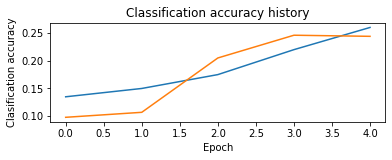

In [5]:
import matplotlib.pyplot as plt

plt.subplot(2, 1, 1)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

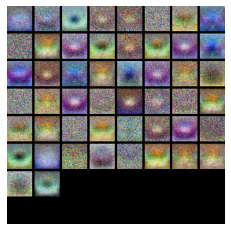

In [6]:
import math 
def visualize_grid(Xs, ubound=255.0, padding=1):
  """
  Reshape a 4D tensor of image data to a grid for easy visualization.

  Inputs:
  - Xs: Data of shape (N, H, W, C)
  - ubound: Output grid will have values scaled to the range [0, ubound]
  - padding: The number of blank pixels between elements of the grid
  """
  (N, H, W, C) = Xs.shape
  grid_size = int(math.ceil(math.sqrt(N)))
  grid_height = H * grid_size + padding * (grid_size - 1)
  grid_width = W * grid_size + padding * (grid_size - 1)
  grid = np.zeros((grid_height, grid_width, C))
  next_idx = 0
  y0, y1 = 0, H
  for y in range(grid_size):
    x0, x1 = 0, W
    for x in range(grid_size):
      if next_idx < N:
        img = Xs[next_idx]
        low, high = np.min(img), np.max(img)
        grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
        # grid[y0:y1, x0:x1] = Xs[next_idx]
        next_idx += 1
      x0 += W + padding
      x1 += W + padding
    y0 += H + padding
    y1 += H + padding
  # grid_max = np.max(grid)
  # grid_min = np.min(grid)
  # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
  return grid

# Visualize the weights of the network

def show_net_weights(net):
  W1 = net.params['W1']
  W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
  plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
  plt.gca().axis('off')
  plt.show()

show_net_weights(net)

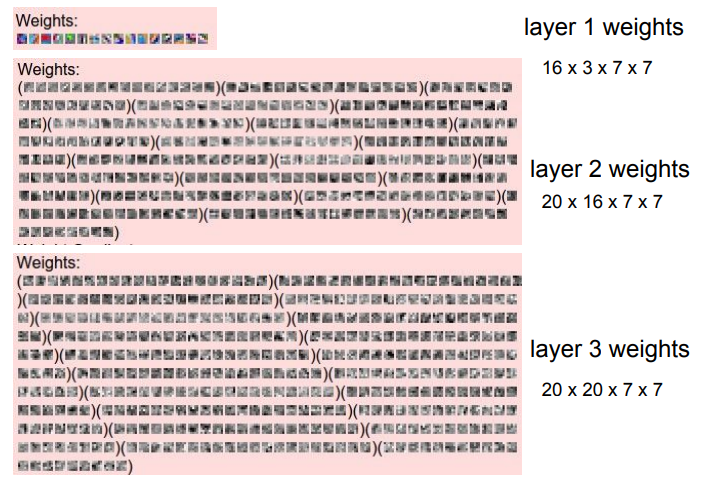

생각보다 흥미롭지 않음. 해석하기 힘듬

Input 이미지와 직접적으로 연결되어 있지 않음

그러나 두번째 레이어는 첫번째 레이어와 연결되어 있기 때문에 첫번째 이후의 Activation 패턴을 알 수 있음.
 그러나 해석이 힘들기 때문에 다른 방법을 찾아야 합니다

#### Last Layer : Dimensionality Reduction
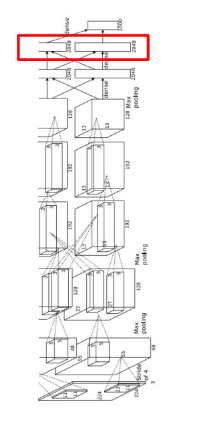

#### t-SNE
image.png